In [1]:
using LazySets, Plots
using LazySets: project, Interval

In [2]:
X = Interval(1.0, 2)

Interval{Float64, IntervalArithmetic.Interval{Float64}}([1, 2])

In [3]:
f(x) = 2*x;

In [4]:
F(X) = Interval(f(X.dat))  # f(X)

F (generic function with 1 method)

In [5]:
Y = cartesian_product(X, F(X))  # X × f(X)

Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([1.5, 3.0], [0.5, 1.0])

In [6]:
Z = LineSegment(low(Y), high(Y))  # {(x, f(x)) | x ∈ X}

LineSegment{Float64, Vector{Float64}}([1.0, 2.0], [2.0, 4.0])

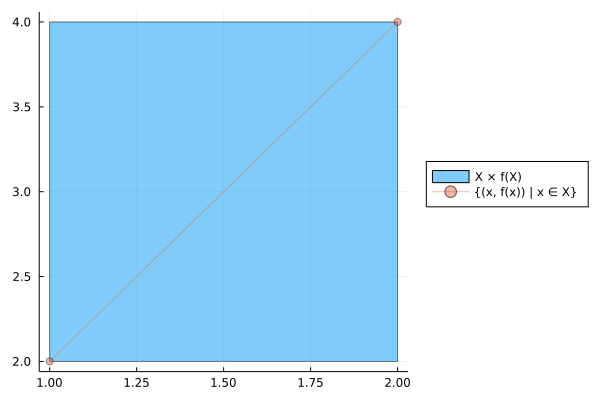

In [7]:
plot(leg=:outerright)
plot!(Y, lab="X × f(X)")
plot!(Z, lab="{(x, f(x)) | x ∈ X}")

In [8]:
using ReachabilityAnalysis, Polyhedra, DifferentialEquations
const DE = DifferentialEquations;

In [9]:
A = [0.0 1; 0 0]

2×2 Matrix{Float64}:
 0.0  1.0
 0.0  0.0

In [10]:
@taylorize function dyn_nln!(dx, x, p, t)
    dx[1] = x[2]
    dx[2] = zero(x[2])
    return nothing
end

In [11]:
U = ZeroSet(1)
XU = cartesian_product(X, U)
ivp_lin = @ivp(x' = A * x, dim: 2, x(0) ∈ XU)
ivp_nln = @ivp(x' = dyn_nln!(x), dim: 2, x(0) ∈ XU)
period = 0.1
T = 0.2;
tspan = 0.0 .. T
cpost_lin = ReachabilityAnalysis._default_cpost(ivp_lin, tspan);
cpost_nln = ReachabilityAnalysis._default_cpost(ivp_nln, tspan);
steps = ceil(Int, T / period);

In [12]:
controller = X -> f(X);

In [13]:
function _solve_ensemble(ivp, X0_samples, tspan;
                         trajectories_alg=DE.Tsit5(),
                         ensemble_alg=DE.EnsembleThreads(),
                         inplace=true,
                         kwargs...)
    if inplace
        field = ReachabilityAnalysis.inplace_field!(ivp)
    else
        field = ReachabilityAnalysis.outofplace_field(ivp)
    end

    _prob_func(prob, i, repeat) = remake(prob, u0=X0_samples[i])
    ensemble_prob = EnsembleProblem(ODEProblem(field, first(X0_samples), tspan),
                                    prob_func=_prob_func)
    return DE.solve(ensemble_prob, trajectories_alg, ensemble_alg;
                    trajectories=length(X0_samples))
end

_solve_ensemble (generic function with 1 method)

In [14]:
function simulate(ivp, controller, steps; trajectories=1, include_vertices=true)
    X0 = project(initial_state(ivp), [1])
    t1 = 0.0
    
    states = sample(X0, trajectories; include_vertices=include_vertices)
    # println(states)
    trajectories = length(states)
    extended = Vector{Vector{Float64}}(undef, trajectories)
    simulations = Vector{EnsembleSolution}(undef, steps)
    
    for k in 1:steps
        # println("k = $k")
        for j in 1:trajectories
            x0 = states[j]
            control = controller(x0)
            extended[j] = vcat(x0, control)
            # println(extended[j])
        end
        
        t2 = t1 + period
        simulations[k] = _solve_ensemble(ivp, extended, (t1, t2); inplace=true)
        
        for j in 1:trajectories
            ode_solution = simulations[k][j]
            final_extended = ode_solution.u[end]
            states[j] = final_extended[1:1]
        end
        t1 = t2
    end
    return simulations
end

simulate (generic function with 1 method)

In [15]:
function solve1(ivp, controller, steps, cpost; time_shift=false)
    S = system(ivp)
    XU = initial_state(ivp)
    t = 0.0
    
    NT = ReachabilityAnalysis.numtype(cpost)
    RT = rsetrep(cpost)
    FT = Flowpipe{NT, RT, Vector{RT}}
    out = Vector{FT}(undef, steps)
    X0s = Vector{Hyperrectangle}(undef, steps)
    solts = Vector(undef, steps)
    
    for k in 1:steps     
        X = convert(Interval, project(XU, [1]))
        U = convert(Interval, controller(X))  # next inputs
        
        X0_cont = cartesian_product(X, U)
        X0s[k] = X0_cont
        
        if time_shift
            dt = 0 .. period
        else
            dt = t .. t + period
        end
        sol = ReachabilityAnalysis.post(cpost, IVP(S, X0_cont), dt)
        if time_shift
            sol = shift(sol, t)
        end
        out[k] = sol
        
        t = t + period
        XU = sol(t)
        XU = set(overapproximate(XU, Zonotope))
        solts[k] = XU
    end
    return MixedFlowpipe(out), X0s, solts
end

solve1 (generic function with 1 method)

In [16]:
function solve2(ivp, controller, steps, cpost; time_shift=false)
    S = system(ivp)
    XU = initial_state(ivp)
    t = 0.0
    
    NT = ReachabilityAnalysis.numtype(cpost)
    RT = rsetrep(cpost)
    FT = Flowpipe{NT, RT, Vector{RT}}
    out = Vector{FT}(undef, steps)
    X0s = Vector{LineSegment}(undef, steps)
    solts = Vector(undef, steps)
    
    for k in 1:steps     
        X = convert(Interval, project(XU, [1]))
        Y = cartesian_product(X, F(X))  # X × f(X)
        
        X0_cont = LineSegment(low(Y), high(Y))  # {(x, f(x)) | x ∈ X}
        X0s[k] = X0_cont
        
        if time_shift
            dt = 0 .. period
        else
            dt = t .. t + period
        end
        sol = ReachabilityAnalysis.post(cpost, IVP(S, X0_cont), dt)
        if time_shift
            sol = shift(sol, t)
        end
        out[k] = sol
        
        t = t + period
        XU = sol(t)
        XU = set(overapproximate(XU, Zonotope))
        solts[k] = XU
    end
    return MixedFlowpipe(out), X0s, solts
end

solve2 (generic function with 1 method)

In [17]:
sim = simulate(ivp_nln, controller, steps, trajectories=100);
S1, X0s1, solts1 = solve1(ivp_nln, controller, steps, cpost_nln);
S2, X0s2, solts2 = solve2(ivp_nln, controller, steps, cpost_nln);

In [ ]:
vars = (1, 2)
fig = plot(xlab=(vars[1] == 0 ? "t" : "x$(vars[1])"), ylab=(vars[2] == 0 ? "t" : "x$(vars[2])"), leg=:outerright)
plot!(fig, S1[1], vars=vars, lab="S1-1")
plot!(fig, S2[1], vars=vars, lab="S2-1")
#plot!(fig, S1[2], vars=vars, lab="S1-2")
#plot!(fig, S2[2], vars=vars, lab="S2-2")
if 0 ∉ vars
    plot!(fig, LineSegment([low(X, 1), low(F(X), 1)], [high(X, 1), high(F(X), 1)]), c=:yellow, lab="X0")
end
#plot!(X0s1[1], lab="X01-1")
#plot!(X0s2[1], lab="X02-1")
#plot!(X0s1[2], lab="X01-2")
#plot!(X0s2[2], lab="X02-2")
xl = Plots.xlims(fig)
yl = Plots.ylims(fig)
for simulation in sim
    for piece in simulation
        Plots.plot!(fig, piece, vars=vars, color=:red, lab="")
    end
    break  # only show first step
end
Plots.xlims!(fig, xl)
Plots.ylims!(fig, yl)
fig

In [ ]:
sim = simulate(ivp_lin, controller, steps, trajectories=100);
S1, X0s1, solts1 = solve1(ivp_lin, controller, steps, cpost_lin; time_shift=true);
S2, X0s2, solts2 = solve2(ivp_lin, controller, steps, cpost_lin; time_shift=true);

In [ ]:
vars = (1, 2)
fig = plot(xlab=(vars[1] == 0 ? "t" : "x$(vars[1])"), ylab=(vars[2] == 0 ? "t" : "x$(vars[2])"), leg=:outerright)
plot!(fig, S1[1], vars=vars, lab="S1-1")
plot!(fig, S2[1], vars=vars, lab="S2-1")
#plot!(fig, S1[2], vars=vars, lab="S1-2")
#plot!(fig, S2[2], vars=vars, lab="S2-2")
if 0 ∉ vars
    plot!(fig, LineSegment([low(X, 1), low(F(X), 1)], [high(X, 1), high(F(X), 1)]), c=:yellow, lab="X0")
end
#plot!(X0s1[1], lab="X01-1")
#plot!(X0s2[1], lab="X02-1")
#plot!(X0s1[2], lab="X01-2")
#plot!(X0s2[2], lab="X02-2")
xl = Plots.xlims(fig)
yl = Plots.ylims(fig)
for simulation in sim
    for piece in simulation
        Plots.plot!(fig, piece, vars=vars, color=:red, lab="")
    end
    break  # only show first step
end
Plots.xlims!(fig, xl)
Plots.ylims!(fig, yl)
fig